In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:

import numpy as np
import os
from matplotlib import pyplot as plt
import cv2
import random
import pickle


file_list = []
class_list = []

DATADIR = "../input/mendeleydatabloodsmearanalysis/PBC_dataset_normal_DIB/PBC_dataset_normal_DIB"

# All the categories you want your neural network to detect
CATEGORIES = ["basophil","eosinophil","erythroblast","ig","lymphocyte","monocyte","neutrophil","platelet"]

# The size of the images that your neural network will use
IMG_SIZE = 359

# Checking or all images in the data folder
'''for category in CATEGORIES :
    path = os.path.join(DATADIR, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))'''
        

training_data = []

def create_training_data():
    for category in CATEGORIES :
        path = os.path.join(DATADIR, category)
        class_num = CATEGORIES.index(category)
        m = 0
        print(category)
        for imagename in os.listdir(path):
            if m<200:
                print(os.path.join(path, imagename))
                final_img = preprocessing_img(cv2.cvtColor(cv2.imread(os.path.join(path, imagename)), cv2.COLOR_BGR2RGB))
                plt.imshow(return_crop(final_img))
                plt.show()
                training_data.append([return_crop(final_img), class_num])
                m+=1
                print(m)
            else:
                break

            

create_training_data()

random.shuffle(training_data)

X1 = [] #features
y1 = [] #labels

for features, label in training_data:
	X1.append(features)
	y1.append(label)



In [ ]:
X1 = np.array(X1).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

# Creating the files containing all the information about your model
pickle_out = open("X1.pickle", "wb")
pickle.dump(X1, pickle_out)
pickle_out.close()

pickle_out = open("y1.pickle", "wb")
pickle.dump(y1, pickle_out)
pickle_out.close()

In [ ]:
from sklearn.model_selection import train_test_split
x_tr, x_te, y_tr, y_te = train_test_split(X1, y1, )

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv3D, MaxPooling2D
import pickle
from keras.models import model_from_json
from keras.models import load_model
import matplotlib.pyplot as plt

# Opening the files about data

#data from threshold preprocessing
X = pickle.load(open("../input/pickled-mendeley/X.pickle", "rb"))
y = pickle.load(open("../input/pickled-mendeley/y.pickle", "rb"))

#data from mask preprocessing 
X1 = pickle.load(open("../input/new-data/X1.pickle", "rb"))
y1 = pickle.load(open("../input/new-data/y1.pickle", "rb"))

In [2]:
import numpy as np
import keras
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, Conv2D, BatchNormalization, Dropout, MaxPool2D, Input, Softmax, Activation, Flatten, 
concatenate,AveragePooling2D
from keras.models import Model
from keras import optimizers
import os
print(os.listdir("../input"))
import cv2
import scipy
from keras.callbacks import ModelCheckpoint
from keras.utils.vis_utils import plot_model
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

['pickled-mendeley', 'new-data', 'mendeleydatabloodsmearanalysis']


In [5]:
X = np.array(X)
y = np.array(y)
xtr, xte, ytr, yte = train_test_split(X, y,test_size = 0.3, shuffle = True)

y_trainHot = to_categorical(ytr, num_classes = 8)
y_testHot = to_categorical(yte, num_classes = 8)

In [14]:
def keras_model(block_num=2):
    inp = Input(shape=(200,200,3))
    k = BatchNormalization()(inp)
    k = Conv2D(32, (7,7), padding="same",activation="relu",strides=(2,2))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k) 
    k = Conv2D(32, (3,3), padding="same",activation="relu",strides=(1,1))(k)
    k = MaxPool2D(pool_size=(3, 3), padding="same",strides=(2,2))(k)
    for j in range(1,block_num+1):
        out_conv = []
        for i in [(1,1),(3,3),(5,5),(0,0)]:
            p = k
            if i == (1,1):
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            elif i == (0,0):
                p = MaxPool2D(pool_size=(2, 2), padding="same",strides=(1,1))(p)
                out_conv.append(Conv2D(32, (1,1), padding="same",activation="relu")(p))
            else:
                p = Conv2D(32, (1,1), padding="same",activation="relu")(p)
                p = Conv2D(32, i, padding="same",activation="relu")(p)
                out_conv.append(Conv2D(32, i, padding="same",activation="relu")(p))
        x = concatenate(out_conv, axis = -1)
        k = x
    x = MaxPool2D(pool_size=(7, 7), padding="same",strides=(2,2))(x)
    x = Flatten()(x)
    y = Dense(8 ,activation="softmax")(x)
    model = Model(inp, y)
    opt = optimizers.Adam(lr=0.01,decay=0.0001)
    model.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    return model
model = keras_model(4)
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 200, 200, 3)  12          input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_114 (Conv2D)             (None, 100, 100, 32) 4736        batch_normalization_8[0][0]      
__________________________________________________________________________________________________
max_pooling2d_23 (MaxPooling2D) (None, 50, 50, 32)   0           conv2d_114[0][0]                 
_______________________________________________________________________________________

In [15]:
filepath = "./cells.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = model.fit(xtr,
         y_trainHot,
         epochs = 40,
         batch_size = 32,
         validation_data = (xte,y_testHot),
         callbacks = callbacks_list,
         verbose = 1)
model.save("cells.h5")

Epoch 1/40
18/18 [==============================] - 1s 61ms/step - loss: 2.1237 - accuracy: 0.1239 - val_loss: 2.0773 - val_accuracy: 0.1481
Epoch 2/40
18/18 [==============================] - 1s 34ms/step - loss: 2.0383 - accuracy: 0.1487 - val_loss: 2.9497 - val_accuracy: 0.1481
Epoch 3/40
18/18 [==============================] - 1s 34ms/step - loss: 1.8572 - accuracy: 0.2496 - val_loss: 2.2657 - val_accuracy: 0.2881
Epoch 4/40
18/18 [==============================] - 1s 34ms/step - loss: 1.3395 - accuracy: 0.5080 - val_loss: 3.7711 - val_accuracy: 0.2016
Epoch 5/40
18/18 [==============================] - 1s 37ms/step - loss: 1.1800 - accuracy: 0.5611 - val_loss: 1.0943 - val_accuracy: 0.6337
Epoch 6/40
18/18 [==============================] - 1s 36ms/step - loss: 1.0328 - accuracy: 0.6496 - val_loss: 1.0822 - val_accuracy: 0.6584
Epoch 7/40
18/18 [==============================] - 1s 34ms/step - loss: 0.7943 - accuracy: 0.7168 - val_loss: 1.0756 - val_accuracy: 0.6091
Epoch 8/40
18

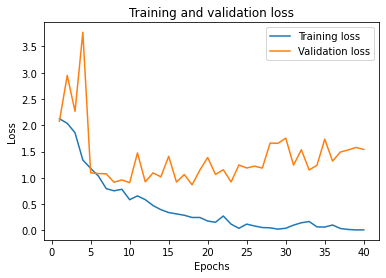

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

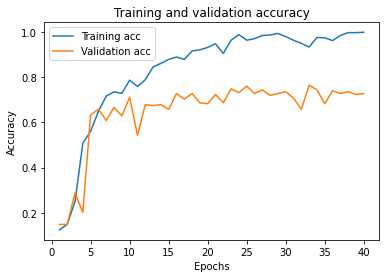

In [18]:
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [19]:
model.load_weights(filepath)
from keras.preprocessing.image import ImageDataGenerator
datagentrain = ImageDataGenerator(featurewise_center=False,
                samplewise_center=False,
                featurewise_std_normalization=False,
                samplewise_std_normalization=False,
                zca_whitening=False, zca_epsilon=1e-06,
                rotation_range=5, width_shift_range=0.0,
                height_shift_range=0.0, brightness_range=None,
                shear_range=0, zoom_range=0.0,
                channel_shift_range=0.0, fill_mode='nearest',
                cval=0.0, horizontal_flip=True, vertical_flip=True,
                rescale=None, preprocessing_function=None,
                data_format=None, validation_split=0.0)
datagentrain.fit(xtr)
history = model.fit_generator(datagentrain.flow(xtr, y_trainHot, batch_size=32),
                    steps_per_epoch=64,
                    epochs=45,
                    workers=4,
                    use_multiprocessing=True,validation_data = (xte,y_testHot),
         callbacks = callbacks_list,)

Epoch 1/64
64/64 [==============================] - 20s 316ms/step - loss: 0.6143 - accuracy: 0.7954 - val_loss: 0.5702 - val_accuracy: 0.7942
Epoch 2/64
64/64 [==============================] - 20s 319ms/step - loss: 0.3988 - accuracy: 0.8623 - val_loss: 0.5070 - val_accuracy: 0.8107
Epoch 3/64
64/64 [==============================] - 22s 342ms/step - loss: 0.2496 - accuracy: 0.9122 - val_loss: 0.4371 - val_accuracy: 0.8642
Epoch 4/64
64/64 [==============================] - 21s 331ms/step - loss: 0.2596 - accuracy: 0.9117 - val_loss: 0.5054 - val_accuracy: 0.8395
Epoch 5/64
64/64 [==============================] - 22s 341ms/step - loss: 0.2376 - accuracy: 0.9177 - val_loss: 0.4557 - val_accuracy: 0.8519
Epoch 6/64
64/64 [==============================] - 21s 328ms/step - loss: 0.1297 - accuracy: 0.9566 - val_loss: 0.4864 - val_accuracy: 0.8436
Epoch 7/64
64/64 [==============================] - 21s 324ms/step - loss: 0.2262 - accuracy: 0.9192 - val_loss: 0.5180 - val_accuracy: 0.8519

64/64 [==============================] - 22s 341ms/step - loss: 0.0076 - accuracy: 0.9980 - val_loss: 0.5758 - val_accuracy: 0.9095
Epoch 58/64
64/64 [==============================] - 20s 318ms/step - loss: 6.6632e-04 - accuracy: 1.0000 - val_loss: 0.6562 - val_accuracy: 0.9053
Epoch 59/64
64/64 [==============================] - 22s 345ms/step - loss: 2.6790e-04 - accuracy: 1.0000 - val_loss: 0.6097 - val_accuracy: 0.9136
Epoch 60/64
64/64 [==============================] - 21s 326ms/step - loss: 2.7443e-04 - accuracy: 1.0000 - val_loss: 0.6041 - val_accuracy: 0.9136
Epoch 61/64
64/64 [==============================] - 20s 316ms/step - loss: 1.5433e-04 - accuracy: 1.0000 - val_loss: 0.6194 - val_accuracy: 0.9136
Epoch 62/64
64/64 [==============================] - 22s 338ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.7506 - val_accuracy: 0.9012
Epoch 63/64
64/64 [==============================] - 21s 334ms/step - loss: 0.1186 - accuracy: 0.9712 - val_loss: 1.2518 - val_accur

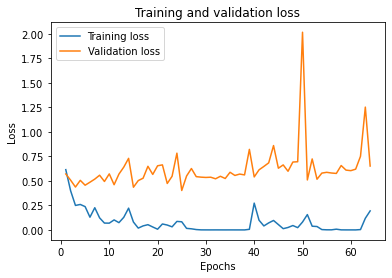

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


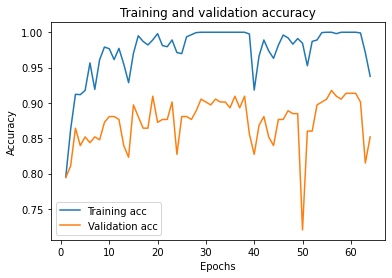

In [22]:
#Accuracy Plot
history_dict = history.history
history_dict.keys()
plt.clf()   # clear figure
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [24]:
predictions = model.predict(xte)

In [34]:
CATEGORIES = ["basophil","eosinophil","erythroblast","ig","lymphocyte","monocyte","neutrophil","platelet"]

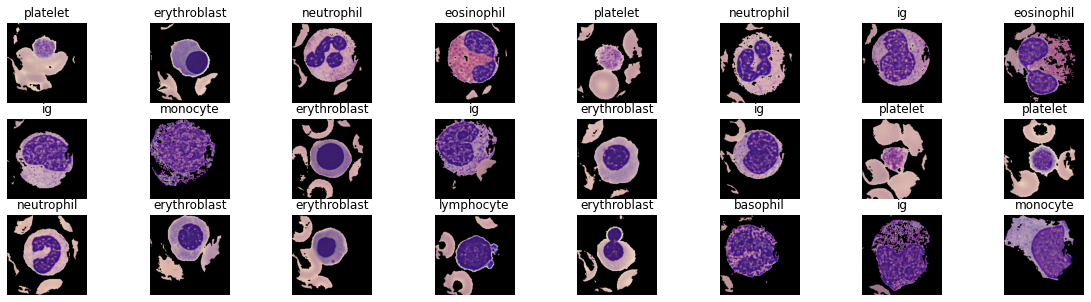

In [48]:
fig=plt.figure(figsize=(20,5))
columns = 8
rows = 3
ax = []

for i in range(columns*rows):
    img = xte[i-1].copy()
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title(str(CATEGORIES[list(predictions[i-1][:]).index(max(np.array(predictions)[i-1,:]))]))
    plt.axis('off')
    plt.imshow(img)


# Preprocessing Functions Explained

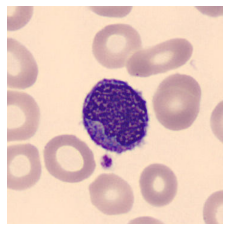

In [50]:
import glob
import cv2
import numpy as np
import skimage
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage as ndi
import time
from skimage import (
    color, feature, filters, io, measure, morphology, segmentation, util
)
image = cv2.cvtColor(cv2.imread('../input/mendeleydatabloodsmearanalysis/PBC_dataset_normal_DIB/PBC_dataset_normal_DIB/monocyte/MO_103089.jpg'), cv2.COLOR_BGRA2RGB)
plt.imshow(image)
plt.axis('off')
plt.show()

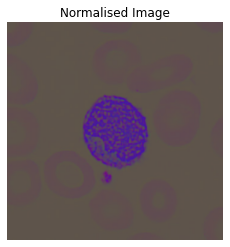

In [51]:
def get_norm_img(a, display = False):
    img = a.copy()
    norm_img= cv2.merge((np.divide(img[:,:,0],np.sum(img, axis = 2))*255
               ,np.divide(img[:,:,1],np.sum(img, axis = 2))*255
               ,np.divide(img[:,:,2],np.sum(img, axis = 2))*255))
    norm_img = norm_img.astype(np.uint8)
    
    if display:
        plt.imshow(norm_img)
        plt.title('Normalised Image')
        plt.axis('off')
        plt.show()
    return norm_img.copy()

norm_image = get_norm_img(image.copy(), True)


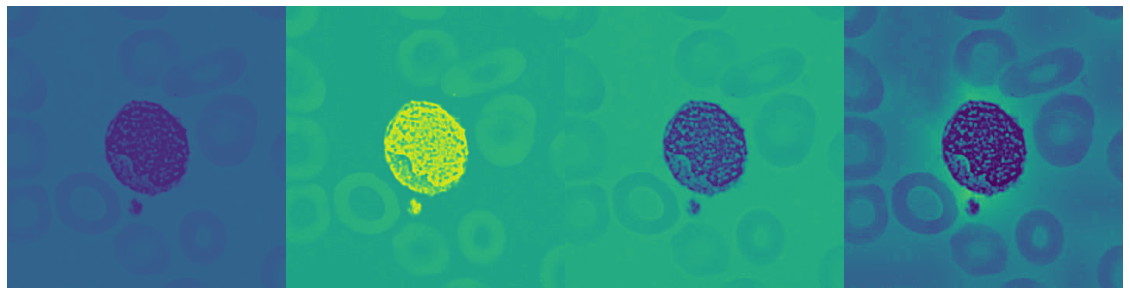

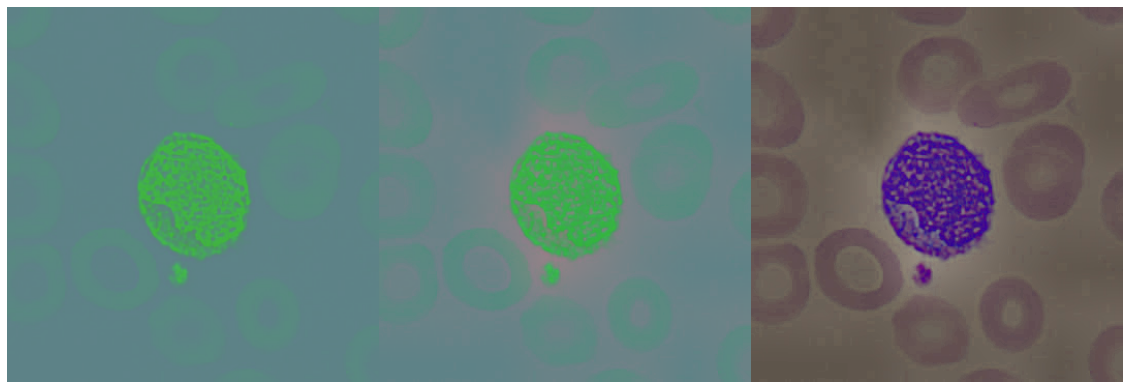

In [52]:
def contrast_enhance(img, x = 1, display = False):
    #-----Converting image to LAB Color model----------------------------------- 
    norm_img = img.copy()
    try:
        lab = cv2.cvtColor(norm_img.copy(), cv2.COLOR_RGB2LAB)
    except:
        lab = cv2.cvtColor(cv2.cvtColor(norm_img.copy(), cv2.COLOR_GRAY2RGB), cv2.COLOR_RGB2LAB)
    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab.copy())
    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    if(x == 1):
        cl = clahe.apply(l.copy())
    else:
        cl = clahe.apply(a.copy())
    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl.copy(),a.copy(),b.copy()))
    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg.copy(), cv2.COLOR_LAB2RGB)
    if display:
        res_1 = np.hstack((l,a,b,cl))
        res_2 = np.hstack((lab,limg,final))
        plt.figure(figsize=(20,40))
        plt.axis('off')
        plt.imshow(res_1)
        plt.show()
        plt.figure(figsize=(20,40))
        plt.axis('off')
        plt.imshow(res_2)
        plt.show()
    return final
    #_____END_____#
final = contrast_enhance(norm_image.copy(), 1, True)

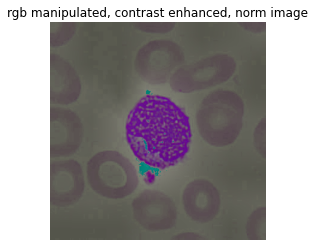

In [53]:
def wbc_rgb_man(img, display = False):
    final = img.copy()
    final = cv2.merge((np.add(final[:,:,0], final[:,:,2])//2, final[:,:,1:])).astype(np.uint8)
    if(display):
        plt.axis('off')
        plt.title('rgb manipulated, contrast enhanced, norm image')
        plt.imshow(final)
        plt.show()
    return final
final = wbc_rgb_man(final.copy(), True)

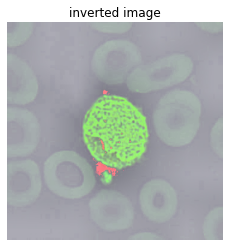

In [54]:
invert_contrast_img = cv2.bitwise_not(final.copy())
plt.imshow(invert_contrast_img)
plt.axis('off')
plt.title('inverted image')
plt.show()

['RED', 'GREEN', 'BLUE']


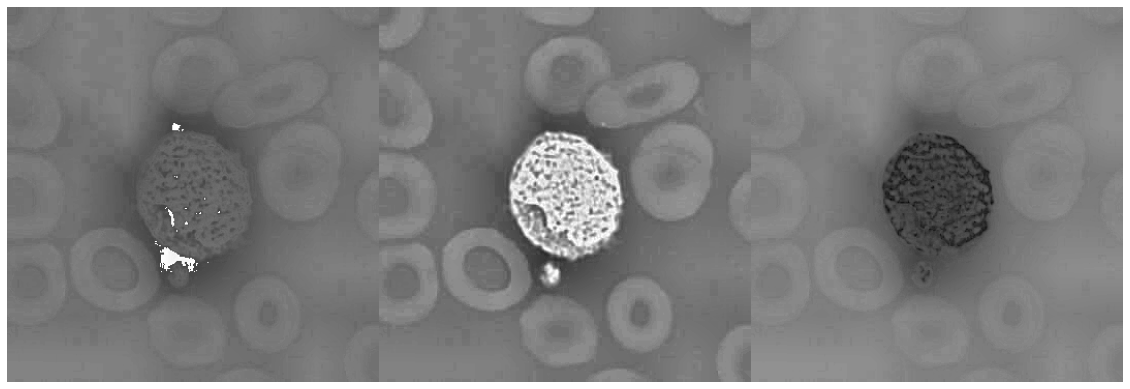

In [55]:
a = ['RED','GREEN','BLUE']
print(a)
red_channel_img = invert_contrast_img[:,:,0]
green_channel_img = invert_contrast_img[:,:,1]
blue_channel_img = invert_contrast_img[:,:,2]
res = np.hstack((red_channel_img,green_channel_img,blue_channel_img)) #stacking images side-by-side
plt.figure(figsize=(20,40))
plt.axis('off')
plt.imshow(res, 'gray')
plt.show()

In [57]:
def plot_channel_histogram(img_input, display = False):
    histogram_data = np.array(np.unique(img_input, return_counts=True))
    indices = list(histogram_data[0])
    values = list(histogram_data[1])
    bins = range(256)
    hist_values = []
    for i in range(256):
        if i in indices:
            hist_values.append(values[indices.index(i)])
        else:
            hist_values.append(0)
    if display:
        fig = plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.bar(bins,hist_values)
        plt.title('COLOR HISTOGRAM')
        plt.show()
    return dict({'indices':indices, 'values':values})

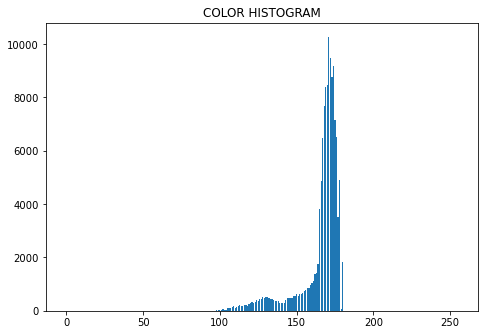

In [58]:
data_orig = plot_channel_histogram(blue_channel_img.copy(), True)

In [59]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [60]:
def get_thresh(data, display = False):
    indices = data['indices']
    values = data['values']
    avg_px = np.sum(np.multiply(indices, values))//np.sum(values)
    
    avg_px = find_nearest(indices, avg_px)
    UT = np.sum(np.multiply(indices[indices.index(avg_px):],values[indices.index(avg_px):]))//np.sum(values[indices.index(avg_px):])
    
    LT = np.sum(np.multiply(indices[0:indices.index(avg_px)+1],values[0:indices.index(avg_px)+1]))//np.sum(values[0:indices.index(avg_px)+1])
    if display:
        print('LT = ',LT)
        print('avg = ',avg_px)
        print('UT = ',UT)
    return dict({'avg':avg_px,'UT':UT,'LT':LT})
thresholds_orig = get_thresh(data_orig.copy(), True) 

LT =  146
avg =  165
UT =  171


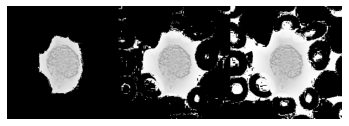

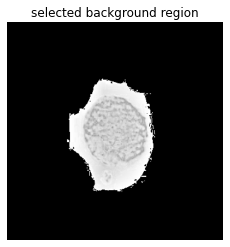

In [61]:
def foreground_enhancement(channel_img,thresh, n = 1, display = False):
    avg_px = thresh['avg']
    UT = thresh['UT']
    LT = thresh['LT']
    frgnd_enhanced_1 = channel_img.copy()
    frgnd_enhanced_2 = channel_img.copy()
    frgnd_enhanced_3 = channel_img.copy()
    frgnd_enhanced_1[channel_img>(avg_px+LT)//2] = 0
    frgnd_enhanced_2[channel_img>avg_px//2] = 0
    frgnd_enhanced_3[channel_img>(avg_px+UT)//2] = 0
    for i in range(channel_img.shape[0]):
        for j in range(channel_img.shape[1]):
            if channel_img[i,j]<=(avg_px+LT)//2:
                frgnd_enhanced_1[i,j] = channel_img[i,j]
            else:
                frgnd_enhanced_1[i,j] = 0
            if channel_img[i,j]<=avg_px:
                frgnd_enhanced_2[i,j] = channel_img[i,j]
            else:
                frgnd_enhanced_2[i,j] = 0
            if channel_img[i,j]<=(avg_px+UT)//2:
                frgnd_enhanced_3[i,j] = channel_img[i,j]
            else:
                frgnd_enhanced_3[i,j] = 0
    if display:
        res = np.hstack((frgnd_enhanced_1,frgnd_enhanced_2,frgnd_enhanced_3))
        plt.imshow(res, 'gray')
        plt.axis('off')
        plt.show()
    if n==1:
        return frgnd_enhanced_1
    elif n==2:
        return frgnd_enhanced_2
    elif n==3:
        return frgnd_enhanced_3
bg_region = foreground_enhancement(blue_channel_img.copy(),thresholds_orig, 1, True)
plt.imshow(bg_region, 'gray')
plt.title('selected background region')
plt.axis('off')
plt.show()

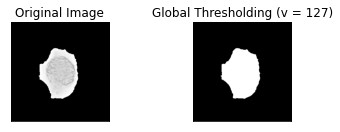

In [62]:
def binarizing_img(enh_reg,n = 1,display = False):
    gray_img = enh_reg.copy()
    plt.imshow(gray_img,'gray')

    blur_img = cv2.medianBlur(gray_img.copy(),5)

    ret,th1 = cv2.threshold(blur_img,127,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    '''th2 = cv2.adaptiveThreshold(blur_img,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
                cv2.THRESH_BINARY,11,2)
    th3 = cv2.adaptiveThreshold(blur_img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
                cv2.THRESH_BINARY,11,2)'''

    images = [blur_img, th1]
    if display:
        titles = ['Original Image', 'Global Thresholding (v = 127)']
        for i in range(2):
            plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
            plt.title(titles[i])
            plt.xticks([]),plt.yticks([])
        plt.show()
    return images[n]
bg_region_binary = binarizing_img(bg_region.copy(), 1, True)

# Getting the WBC inner region

In [ ]:
def morph_img(gray, n = 1):
    # noise removal
    kernel = np.ones((3,3),np.uint8)
    opening = cv2.morphologyEx(gray.copy(),cv2.MORPH_OPEN,kernel, iterations = 6)
    # sure background area
    sure_bg = cv2.dilate(opening,kernel,iterations=8)
    if n==1:
        return opening
    elif n==2:
        return sure_bg
#opening = morph_img(bg_region_binary.copy())
#plt.imshow(opening, 'gray')

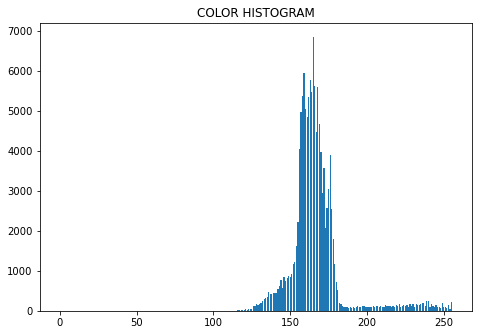

In [63]:
data_orig = plot_channel_histogram(green_channel_img.copy(), True)

In [64]:
thresholds_orig = get_thresh(data_orig.copy(), True)

LT =  157
avg =  166
UT =  178


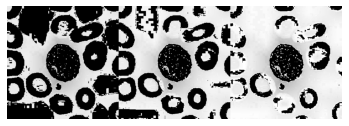

In [65]:
fg_region = foreground_enhancement(green_channel_img.copy(),thresholds_orig,1, True)

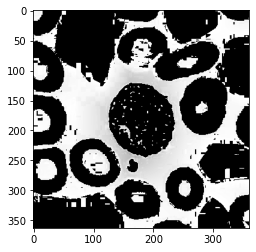

In [66]:
fg_reg_binary = binarizing_img(fg_region.copy())

In [67]:
def filling_holes(morphed_img, display = False):
    #filling holes
    des = cv2.bitwise_not(morphed_img.copy())
    contour,hier = cv2.findContours(des,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_SIMPLE)

    for cnt in contour:
        cv2.drawContours(des,[cnt],0,255,-1)

    gray = cv2.bitwise_not(des)
    if display:
        plt.imshow(np.hstack((morphed_img,des,gray)), 'gray')
        plt.axis('off')
        plt.title('Images From the Process')
        plt.show()

        plt.imshow(gray, 'gray')
        plt.axis('off')
        plt.title('Holes Filled')
        plt.show()
   
    return gray

In [68]:
def draw_contours(image, filled):
    contours, hierarchy = cv2.findContours(filled.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    test_img = image.copy()
    for i in range(len(contours)):
        color_contours = (0, 0, 0) # green - color for contours
        # draw ith contour
        cv2.drawContours(test_img, np.array(contours), i, color_contours, 2, 8, hierarchy)
    #plt.imshow(test_img)
    return test_img, contours

In [69]:
def return_reg_3d(imgr, reg):
    return_img = imgr.copy()
    return_img[reg == 0] = 0
    #plt.imshow(return_img)
    return return_img
#return_img = return_reg_3d(image.copy(), bg_region_binary.copy())
                

In [70]:
def return_reg_2d(img2, reg):
    return_img1 = img2.copy()
    return_img1[reg == 0] = 0
    plt.imshow(return_img1)
    return return_img1

In [77]:
def get_logic_area(main_cell, new_contours):
    m,n,c = 0,0,0
    for i in range(np.array(new_contours).shape[0]):
        if m<np.array(new_contours)[i].shape[0]:
            m=np.array(new_contours)[i].shape[0]
            n = i
            
    img = main_cell.copy()
    cv2.drawContours(img, new_contours, n, 255, -1) # Draw filled contour in mask
    out = np.zeros_like(img) # Extract out the object and place into output image
    out[img == 255] = img[img == 255]
    mask = cv2.subtract(out[:,:,0], out[:,:,1])
    final_cell = main_cell.copy()
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            if mask[i,j] == 255:
                final_cell[i,j] = main_cell[i,j]
            else:
                final_cell[i,j] = 0
    return final_cell, mask

In [72]:
def return_relevant(im1,filled_img):
    img11 = im1.copy()
    img11[filled_img == 255] = 0
    return img11
    

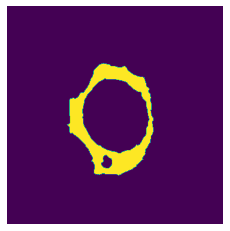

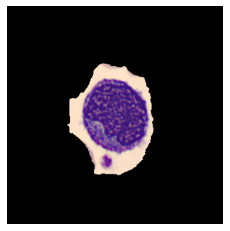

In [73]:
filled_img = return_reg_2d(filling_holes(fg_reg_binary.copy()),bg_region_binary.copy())
plt.imshow(filled_img)
plt.axis('off')
plt.show()
main_cell = return_reg_3d(image.copy(), bg_region_binary.copy())
plt.imshow(main_cell)
plt.axis('off')
plt.show()

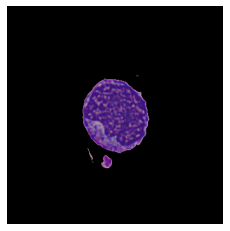

In [74]:
main_cell1 = return_relevant(main_cell.copy(), filled_img.copy())
plt.imshow(main_cell1)
plt.axis('off')
plt.show()

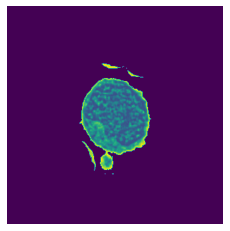

In [75]:
test = main_cell[:,:,0].copy()
arr = main_cell[:,:,0].copy().reshape(-1)[::-1]
arr[::-1].sort()
val = int(np.mean(arr[0:10000]))
for i in range(main_cell[:,:,0].shape[0]):
    for j in range(main_cell[:,:,0].shape[1]):
        if test[i,j] >= val:
            test[i,j] = 0
plt.imshow(test)
plt.axis('off')
plt.show()

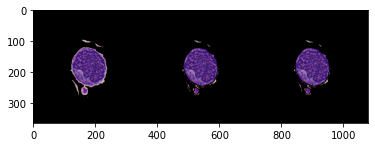

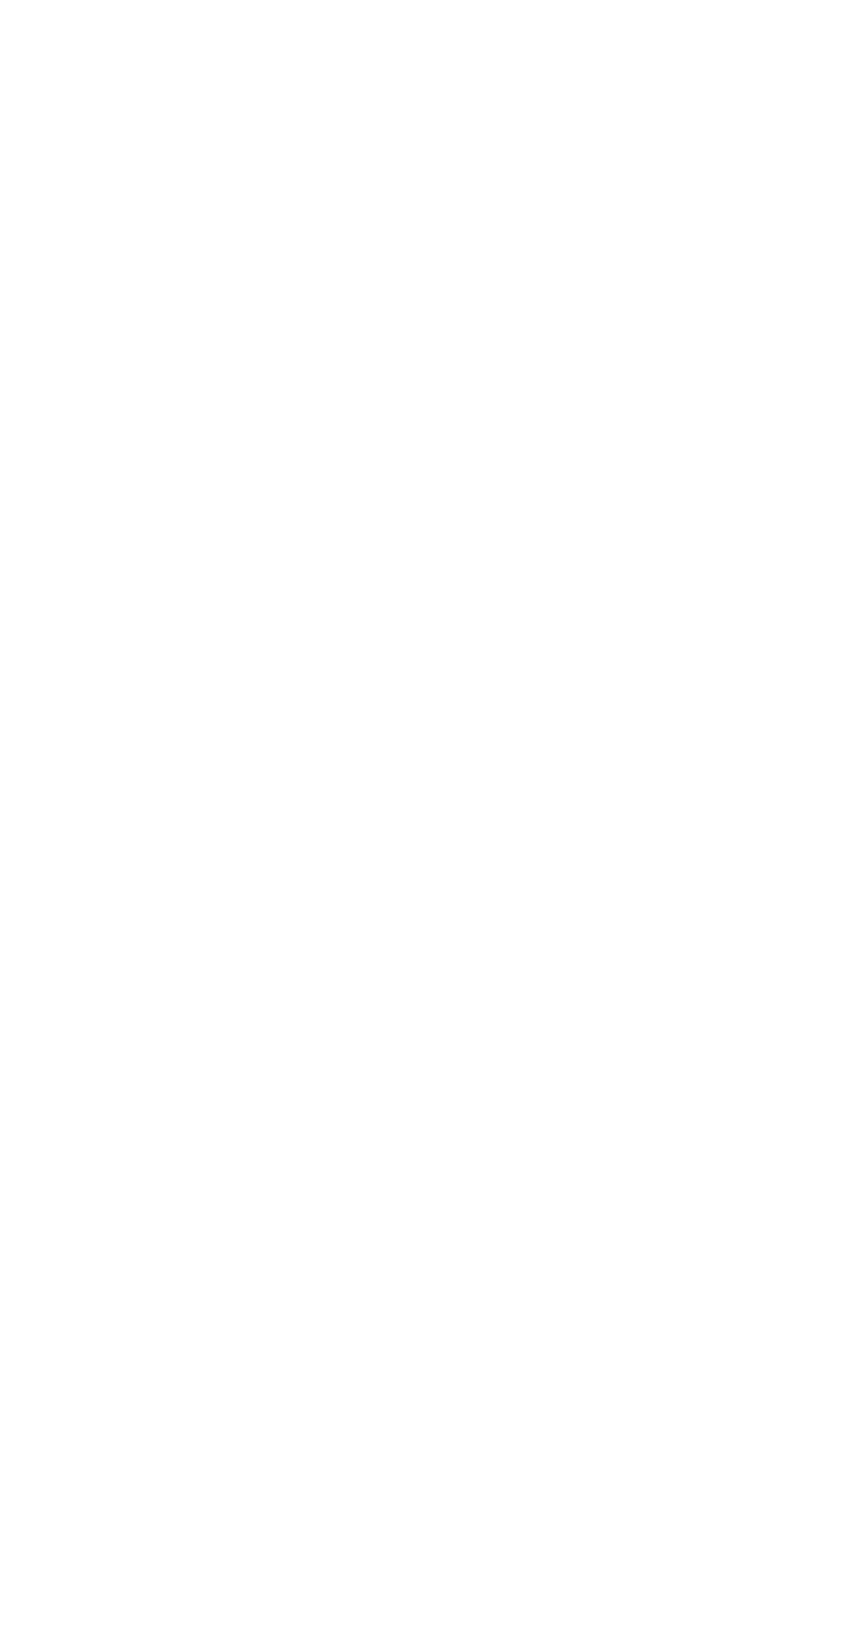

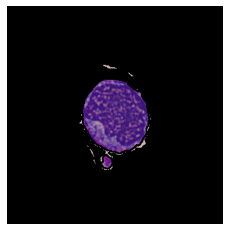

In [79]:
final_wbc = return_reg_3d(image.copy(), test.copy())
contoured_img,contours = draw_contours(final_wbc.copy(), filled_img.copy())
final_cell, mask = get_logic_area(contoured_img, contours)

plt.imshow(np.hstack((final_wbc, contoured_img, final_cell)))
plt.figure(figsize=(15, 30))
plt.axis('off')
plt.show()


plt.imshow(final_cell)
plt.axis('off')
plt.show()

In [80]:
def getting_maincell(img_channel, img12, mode = 1,display = False, bg = 1, fg = 1):
    red_channel_img = img_channel[:,:,0]
    green_channel_img = img_channel[:,:,1]
    blue_channel_img = img_channel[:,:,2]
    if display:
        a = ['RED','GREEN','BLUE']
        print(a)
        res = np.hstack((red_channel_img,green_channel_img,blue_channel_img)) #stacking images side-by-side
        plt.figure(figsize=(20,40))
        plt.axis('off')
        plt.imshow(res, 'gray')
        plt.show()
    
    data_bg = plot_channel_histogram(blue_channel_img.copy())
    data_fg = plot_channel_histogram(green_channel_img.copy())

    
    thresholds_bg = get_thresh(data_bg)
    thresholds_fg = get_thresh(data_fg)
    
    
    bg_region = foreground_enhancement(blue_channel_img.copy(),thresholds_bg, bg)
    fg_region = foreground_enhancement(green_channel_img.copy(),thresholds_fg,fg)
    if display:
        bg_fg = np.hstack((bg_region, fg_region))
        plt.imshow(bg_fg,'gray')
        plt.show()

    bg_reg_binary = binarizing_img(bg_region.copy())
    fg_reg_binary = binarizing_img(fg_region.copy())
    
    if display:
        bg_fg_binary = np.hstack((bg_reg_binary,fg_reg_binary))
        plt.imshow(bg_fg_binary, 'gray')
        plt.axis('off')
        plt.show()

    filled_img = return_reg_2d(filling_holes(fg_reg_binary.copy()),bg_reg_binary.copy())
    #plt.imshow(filled_img)
    #plt.show()
    main_cell = return_reg_3d(img12.copy(), bg_reg_binary.copy())
    '''plt.imshow(main_cell)
    plt.axis('off')
    plt.show()'''
    if mode == 1:
        test = main_cell[:,:,0].copy()
        arr = main_cell[:,:,0].copy().reshape(-1)[::-1]
        arr[::-1].sort()
        val = int(np.mean(arr[0:10000]))
        for i in range(main_cell[:,:,0].shape[0]):
            for j in range(main_cell[:,:,0].shape[1]):
                if test[i,j] >= val:
                    test[i,j] = 0
    else:
        final_cell = return_relevant(main_cell.copy(), filled_img.copy())
        plt.imshow(final_cell)
        plt.show()
        return final_cell
    final_wbc = return_reg_3d(img12.copy(), test.copy())
    '''contoured_img,contours = draw_contours(final_wbc.copy(), filled_img.copy())
    final_cell, n_mask = get_logic_area(contoured_img, contours)'''
    plt.imshow(final_wbc)
    plt.axis('off')
    plt.show()
    return final_wbc

In [82]:
def preprocessing_img(img, mode = 1):
    norm_img = get_norm_img(img.copy())
    final = contrast_enhance(norm_img.copy())
    final = wbc_rgb_man(final.copy())
    invert_contrast_img = cv2.bitwise_not(final.copy())
    final_wbc = getting_maincell(invert_contrast_img.copy(), img.copy(), mode, True)
    return final_wbc

['RED', 'GREEN', 'BLUE']


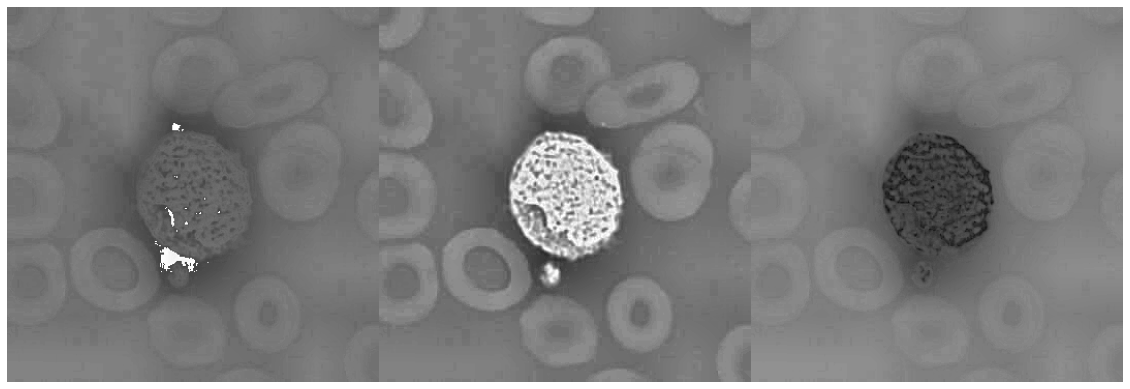

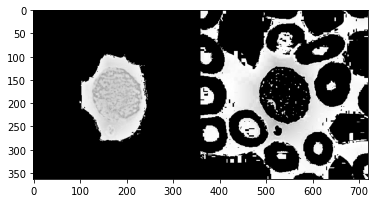

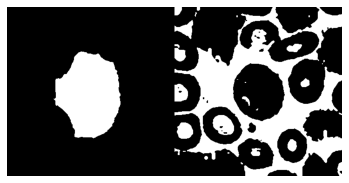

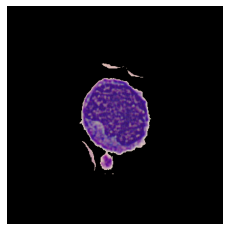

In [83]:
final_wbc = preprocessing_img(image)

['RED', 'GREEN', 'BLUE']


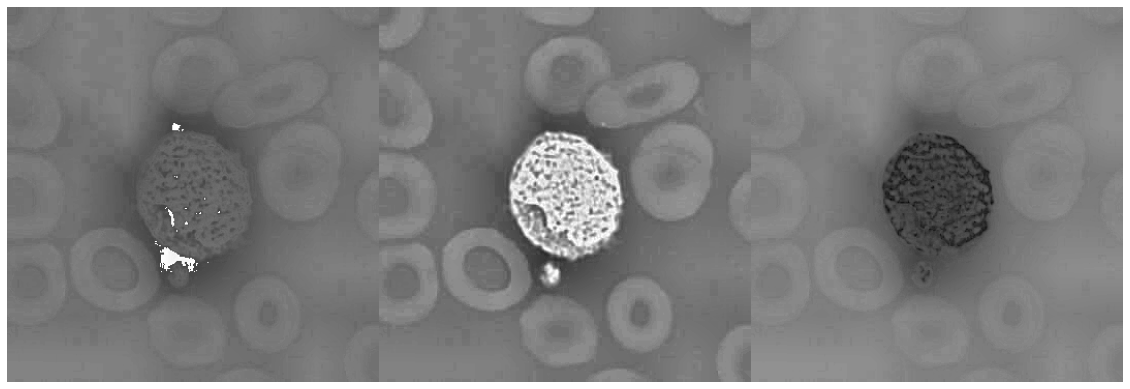

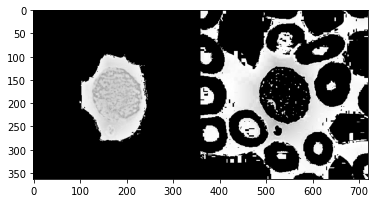

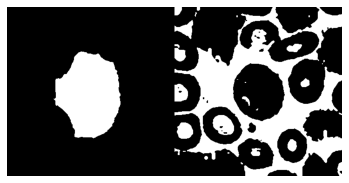

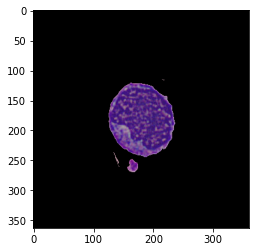

In [84]:
final_wbc = preprocessing_img(image, 2)

In [85]:
def get_mask(final_wbc, display = False):
    w_mask = final_wbc.copy()
    w_mask[final_wbc != [0,0,0]] = 255
    w_mask = cv2.cvtColor(w_mask, cv2.COLOR_RGB2GRAY)
    if display:
        plt.imshow(w_mask)
        plt.title('WBC MASK')
        plt.axis('off')
        plt.show()
    return w_mask

In [86]:
def return_crop(final_wbc, mode = 1, display = False):
    if mode == 1:
        return final_wbc[0:359,0:359]
    else:
        w_mask = get_mask(final_wbc)
        x,y,w,h = cv2.boundingRect(w_mask.copy())
        if display:
            plt.imshow(final_wbc[y:y+200,x:x+200])
    return final_wbc[y:y+200,x:x+200]

['RED', 'GREEN', 'BLUE']


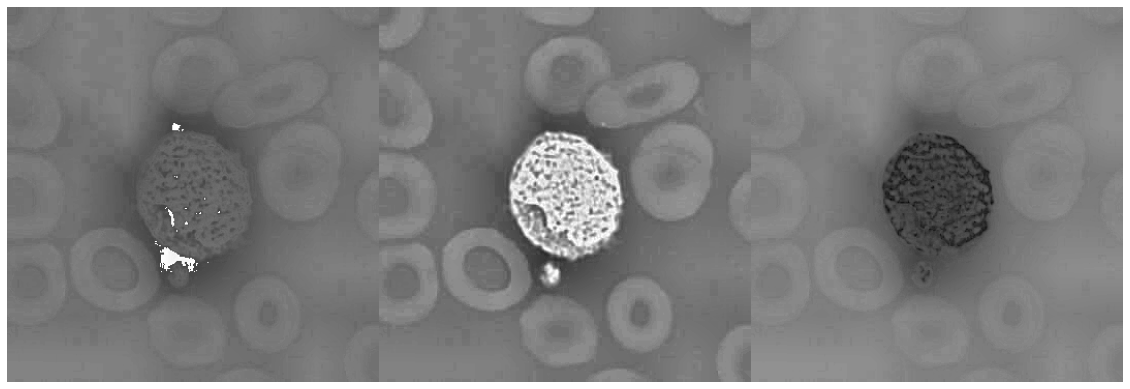

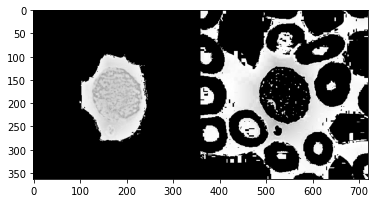

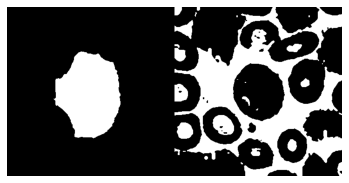

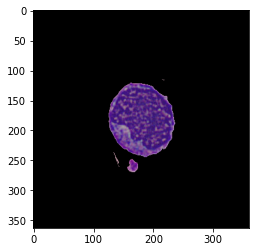

In [87]:
final_wbc = preprocessing_img(image, 2)

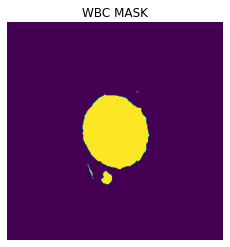

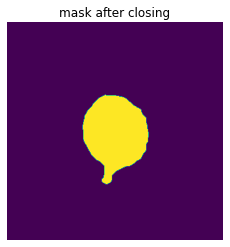

In [89]:
w_mask = get_mask(final_wbc.copy(), True)
w_mask = cv2.morphologyEx(w_mask, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 2)
w_mask = cv2.morphologyEx(w_mask, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7)), iterations = 7)
plt.imshow(w_mask)
plt.title('mask after closing')
plt.axis('off')
plt.show()

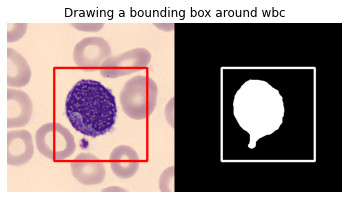

In [90]:
x,y,w,h = cv2.boundingRect(w_mask.copy())
final_img = cv2.rectangle(image.copy(), (x-25,y-25),(x+175, y+175), (255,0,0), 3)
plt.imshow(np.hstack((final_img, cv2.cvtColor(cv2.rectangle(w_mask.copy(), (x-25,y-25),(x+175, y+175), (255,0,0), 3), cv2.COLOR_GRAY2RGB))))
plt.title('Drawing a bounding box around wbc')
plt.axis('off')
plt.show()

# RBC COUNTING

THRESHOLD INTENSITY VALUE706
[255 236 215]


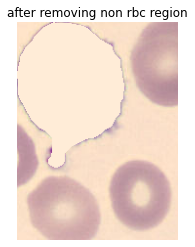

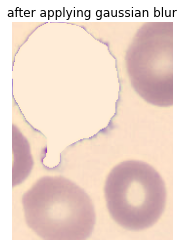

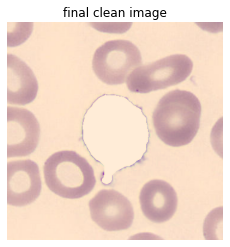

In [91]:
[x,y,w,h] = cv2.boundingRect(w_mask.copy())
cropped_img = image[y:y+3*h//2, x:x+3*w//2].copy()
cropped_mask = w_mask[y:y+3*h//2, x:x+3*w//2].copy()
intensity = cropped_img.sum(axis=2)
#print(intensity)
intensity_val = np.max(intensity)
#print(intensity_val)
print('THRESHOLD INTENSITY VALUE'+str(intensity_val))
result = np.where(intensity == intensity_val)
#print(result)
val = cropped_img[result].mean(axis = 0).astype(int)
print(val)
for i in range(cropped_mask.shape[0]):
    for j in range(cropped_mask.shape[1]):
        if cropped_mask[i,j] != 0:
            cropped_img[i,j,:] = val
plt.imshow(cropped_img)
plt.title('after removing non rbc region')
plt.axis('off')
plt.show()
cropped_img[:,:,2] = cv2.GaussianBlur(cropped_img[:,:,2].copy(),(5,5),8)
plt.imshow(cropped_img)
plt.title('after applying gaussian blur')
plt.axis('off')
plt.show()
clean_image = image.copy()
clean_image[y:y+3*h//2, x:x+3*w//2] = cropped_img
plt.imshow(clean_image)
plt.title('final clean image')
plt.axis('off')
plt.show()

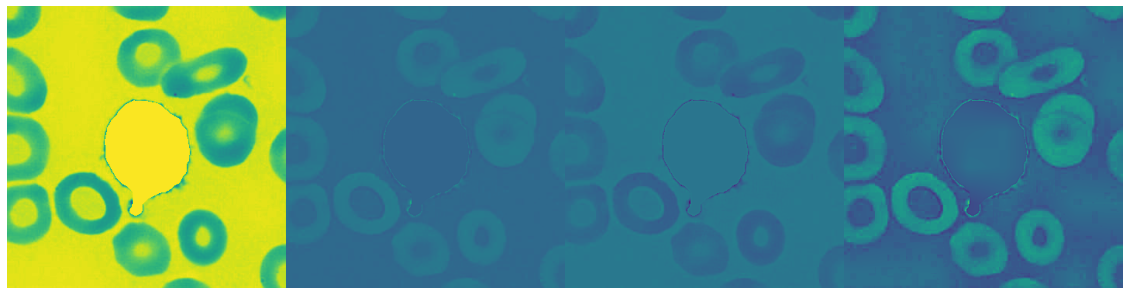

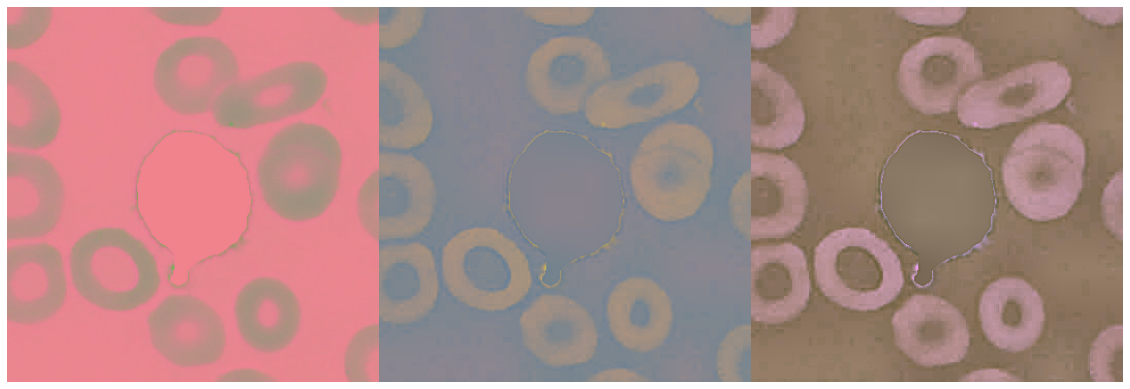

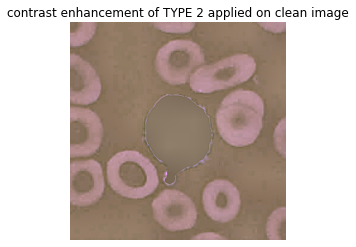

In [92]:
red = contrast_enhance(clean_image.copy(),2, True)
plt.imshow(red)
plt.title('contrast enhancement of TYPE 2 applied on clean image')
plt.axis('off')
plt.show()

['RED', 'GREEN', 'BLUE']


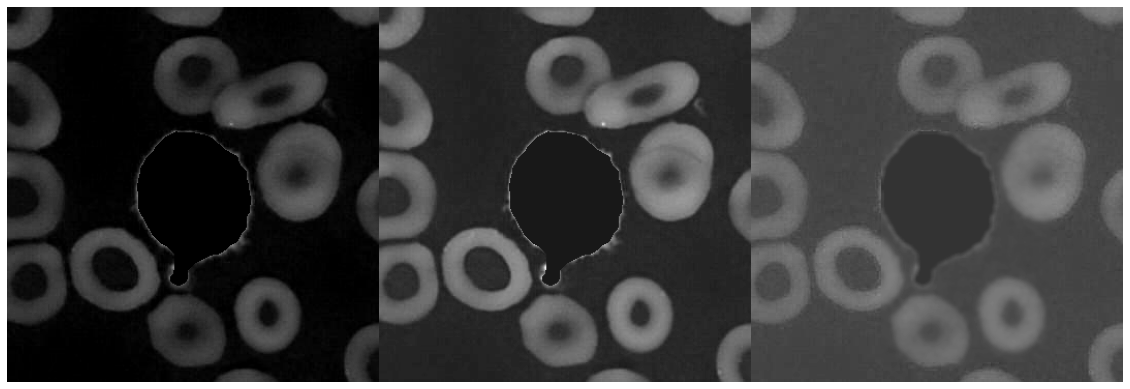

In [93]:
a = ['RED','GREEN','BLUE']
print(a)
red_invert = cv2.bitwise_not(clean_image.copy())
red_channel_img = red_invert[:,:,0]
green_channel_img = red_invert[:,:,1]
blue_channel_img = red_invert[:,:,2]
res = np.hstack((red_channel_img,green_channel_img,blue_channel_img)) #stacking images side-by-side
plt.figure(figsize=(20,40))
plt.axis('off')
plt.imshow(res, 'gray')
plt.show()

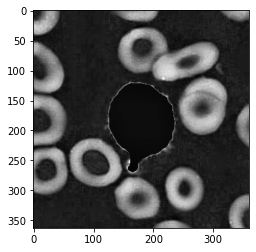

In [94]:
green_channel_img = cv2.cvtColor(contrast_enhance(green_channel_img.copy()), cv2.COLOR_RGB2GRAY)
plt.imshow(green_channel_img, 'gray')

In [95]:
data_red = plot_channel_histogram(green_channel_img.copy())

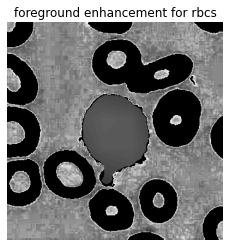

In [97]:
gray = foreground_enhancement(green_channel_img.copy(),get_thresh(data_red), 2)
plt.imshow(gray, 'gray')
plt.title('foreground enhancement for rbcs')
plt.axis('off')
plt.show()

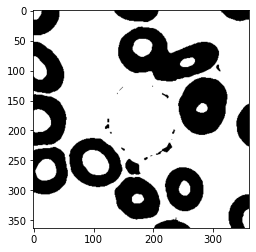

In [98]:
binary_img = binarizing_img(gray, 1)
plt.imshow(binary_img, 'gray')

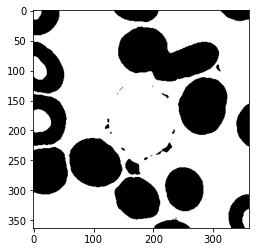

In [99]:
binary_img = filling_holes(binary_img.copy())
plt.imshow(binary_img, 'gray')

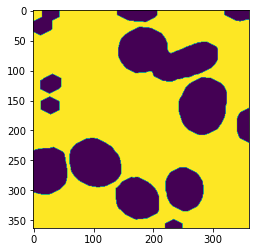

In [100]:
binary_img = cv2.morphologyEx(binary_img, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5)), iterations = 7)
plt.imshow(binary_img)

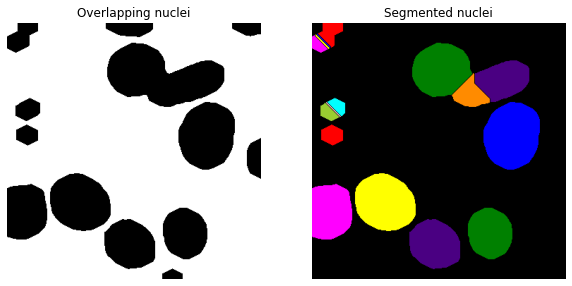

In [101]:
from skimage import measure
labels = measure.label(cv2.bitwise_not(binary_img),connectivity = 2)
distance = ndi.distance_transform_edt(labels.copy())
local_maxi = feature.peak_local_max(distance, indices=False,
                                    min_distance=10)
markers = measure.label(local_maxi)
segmented_cells = segmentation.watershed(-distance, markers, mask=labels, watershed_line = True)

fig, ax = plt.subplots(ncols=2, figsize=(10, 5))
ax[0].imshow(binary_img.copy(), cmap='gray')
ax[0].set_title('Overlapping nuclei')
ax[0].axis('off')
ax[1].imshow(color.label2rgb(segmented_cells, bg_label=0))
ax[1].set_title('Segmented nuclei')
ax[1].axis('off')
plt.show()

RBC COUNT: 16


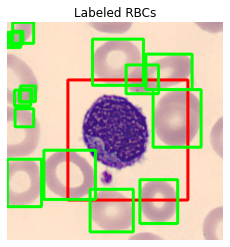

In [102]:
props = measure.regionprops(segmented_cells)
ar = 0
c = 0
for prop in props:
    final_img = cv2.rectangle(final_img, (prop.bbox[1], prop.bbox[0]), (prop.bbox[3],prop.bbox[2]), (0,255,0), 3) 
    c+=1
print('RBC COUNT: '+str(c))
plt.imshow(final_img)
plt.title('Labeled RBCs')
plt.axis('off')
plt.show()

**END OF RBC COUNTING**